In [1]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377 (from 1)
Receiving objects: 100% (386/386), 3.85 MiB | 7.22 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [3]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)


In [3]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


--2024-12-05 16:30:14--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-12-05 16:30:14--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8dcbc4e4bc84317558d40a1fbd.dl.dropboxusercontent.com/cd/0/inline/CfoV7cIlbJBPQowZM7eS9txwmgvzImkSp9-0xLAJtml2BWVgGMPSYTrPdmmnoj2RkK2aKVQSmupguDjDq9V91F30xt3D_PmO4IjW20TotA00v1WdfxD0mBC7Ik9GZV-ias8/file# [following]
--2024-12-05 16:30:15--  https://uc8dcbc4e4bc84317558d40a1fbd.dl.dropboxusercontent.com/cd/0/inline/CfoV7cIlbJBPQowZ

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


In [6]:
from google.colab import drive
from skimage.io import imread
from skimage.transform import resize
import os
import sys
from IPython.display import clear_output
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (15,4)
from PIL import Image

from time import time
import numpy as np
import copy
from dataclasses import dataclass, asdict
import pickle

drive.mount('/content/drive', force_remount=True)
drive_path = "/content/drive/MyDrive/PH2Dataset"

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

Mounted at /content/drive
cuda


In [7]:
import os
from tqdm import tqdm
from skimage.io import imread

images = []
lesions = []

# Path to the root directory of the dataset
root_path = "/content/drive/MyDrive/PH2Dataset/PH2 Dataset images"

all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        image_files = os.listdir(directory)
        if image_files:
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        lesion_files = os.listdir(directory)
        if lesion_files:
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

print(f"Loaded {len(images)} images and {len(lesions)} lesion masks.")


Processing Directories: 100%|██████████| 627/627 [00:08<00:00, 70.04it/s]

Loaded 200 images and 200 lesion masks.


Processing Directories: 100%|██████████| 627/627 [00:06<00:00, 99.04it/s]


Cleaned 200 images, 200 masks, and 200 labels.


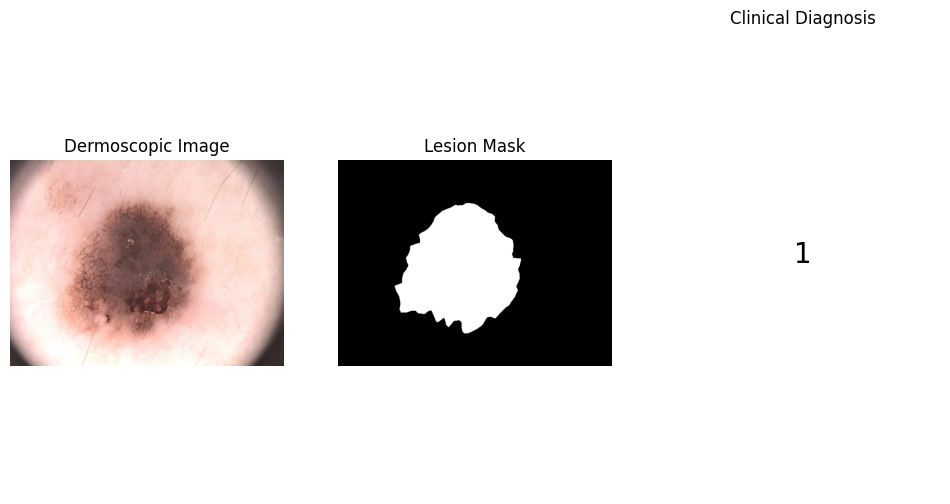

In [8]:
import os
import pandas as pd
from tqdm import tqdm
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

# Paths
root_path = "/content/drive/MyDrive/PH2Dataset/PH2 Dataset images"
metadata_path = "/content/Transformer-Explainability/PH2Dataset/PH2_dataset.txt"

# Load metadata
metadata = pd.read_csv(metadata_path, sep="\\|", engine="python", skipinitialspace=True)
metadata.columns = metadata.columns.str.strip()  # Clean column names
metadata = metadata.dropna(how="all", axis=1)  # Drop empty columns
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names
metadata["Clinical Diagnosis"] = pd.to_numeric(metadata["Clinical Diagnosis"], errors="coerce")

# Remove rows with NaN in Clinical Diagnosis
metadata = metadata.dropna(subset=["Clinical Diagnosis"])
metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)

# Initialize data storage
images = []
lesions = []
image_names = []

# Gather all directories in the root path
all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

# Process directories
for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        # Load the first image file in the directory
        image_files = os.listdir(directory)
        if image_files:  # Ensure the directory is not empty
            image_name = os.path.basename(directory).replace('_Dermoscopic_Image', '')
            image_names.append(image_name)
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        # Load the first lesion file in the directory
        lesion_files = os.listdir(directory)
        if lesion_files:  # Ensure the directory is not empty
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

# Match images, masks, and clinical diagnoses
matched_labels = []
matched_images = []
matched_lesions = []

for i, name in enumerate(image_names):
    label_row = metadata[metadata["Name"] == name]
    if not label_row.empty:
        matched_labels.append(label_row["Clinical Diagnosis"].values[0])
        matched_images.append(images[i] if i < len(images) else None)
        matched_lesions.append(lesions[i] if i < len(lesions) else None)

# Data Cleaning: Remove any unmatched or None entries
cleaned_images = []
cleaned_lesions = []
cleaned_labels = []

for img, lesion, label in zip(matched_images, matched_lesions, matched_labels):
    if img is not None and lesion is not None and not np.isnan(label):
        cleaned_images.append(img)
        cleaned_lesions.append(lesion)
        cleaned_labels.append(label)

# Check the cleaned data
print(f"Cleaned {len(cleaned_images)} images, {len(cleaned_lesions)} masks, and {len(cleaned_labels)} labels.")

# Plot a single sample
if cleaned_images and cleaned_lesions and cleaned_labels:
    sample_index = 0  # Choose the first sample for plotting

    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 3, 1)
    plt.imshow(cleaned_images[sample_index], cmap='gray')
    plt.title("Dermoscopic Image")
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 3, 2)
    plt.imshow(cleaned_lesions[sample_index], cmap='gray')
    plt.title("Lesion Mask")
    plt.axis('off')

    # Display the label
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, str(cleaned_labels[sample_index]), fontsize=20, ha='center')
    plt.title("Clinical Diagnosis")
    plt.axis('off')

    plt.show()
else:
    print("No valid samples to display.")


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, cleaned_labels, test_size=0.2, stratify=cleaned_labels, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Testing size: {len(X_test)}")

X_train = images
X_temp = images
y_train = cleaned_labels
y_temp = cleaned_labels


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

class PH2Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transformations for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize for ViT or CNN input
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip image horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip image vertically
    transforms.RandomRotation(degrees=30),  # Rotate image randomly within ±30 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

# Define validation/test transformations (no augmentations, only resizing and normalization)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = PH2Dataset(X_train, y_train, transform=train_transform)
val_dataset = PH2Dataset(X_temp, y_temp, transform=val_test_transform)
#test_dataset = PH2Dataset(X_test, y_test, transform=val_test_transform)
test_dataset = val_dataset
# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
from collections import Counter
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import classification_report
import numpy as np

# Function to count samples in each class
def count_class_samples(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    return class_counts

# Count samples in train and validation datasets
train_class_counts = count_class_samples(train_dataset)
val_class_counts = count_class_samples(val_dataset)

# Print class distributions
print("Training dataset class distribution:")
for class_id, count in sorted(train_class_counts.items()):
    print(f"  Class {class_id}: {count} samples")

print("Validation dataset class distribution:")
for class_id, count in sorted(val_class_counts.items()):
    print(f"  Class {class_id}: {count} samples")

# Define class weights for imbalanced dataset
total_samples = sum(train_class_counts.values())
class_weights = [total_samples / train_class_counts[c] for c in range(3)]
class_weights = torch.tensor(class_weights).cuda()

# Update the loss function to include weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define training transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define validation/test transformations
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Update datasets with transformations
train_dataset.transform = train_transform
val_dataset.transform = val_test_transform

# Weighted sampler for balanced sampling
sample_weights = [1 / train_class_counts[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Update DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
model = vit_LRP(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Early stopping parameters
best_accuracy = 0
patience = 5
early_stop_count = 0

# Training loop
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Classification report
    if epoch == num_epochs - 1 or accuracy > best_accuracy:
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stop_count = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()


Training dataset class distribution:
  Class 0: 80 samples
  Class 1: 80 samples
  Class 2: 40 samples
Validation dataset class distribution:
  Class 0: 80 samples
  Class 1: 80 samples
  Class 2: 40 samples
Epoch 1, Loss: 0.8263
Validation Accuracy: 70.00%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.69      0.71      0.70        80
     Class 1       0.63      0.64      0.63        80
     Class 2       0.89      0.80      0.84        40

    accuracy                           0.70       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.70      0.70      0.70       200

Epoch 2, Loss: 0.5275
Validation Accuracy: 60.00%
Epoch 3, Loss: 0.5145
Validation Accuracy: 79.50%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.82      0.82        80
     Class 1       0.83      0.66      0.74        80
     Class 2       0.73      1.00      0.84        4

In [25]:
model.eval()

correct, total = 0, 0

for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()

    images.requires_grad_()

    outputs = model(images)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)

    loss.backward()

    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    gradients = images.grad
    print(f"Gradients shape: {gradients.shape}")

test_accuracy = 100 * correct / total
print(correct)
print(total)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([8, 3, 224, 224])
159
200
Test Accuracy: 79.50%


In [13]:
# create heatmap from mask on image
use_thresholding = True
CLS2IDX = {0: 'nevus',
 1: 'atypical nevus',
 2: 'melanoma'}

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

"""# Load the model"""

from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
import torch
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

def generate_visualization(original_image, class_index=None, method = "transformer_attribution"):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

"""# LRP"""
def generate_visualization_LRP(original_image, class_index=None, use_thresholding=False):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis

# Saliency
def generate_saliency_visualization(original_image, class_index=None, use_thresholding=False):
    original_image.requires_grad_()  # Enable gradient tracking for the input image

    # Forward pass through the model
    output = model(original_image.unsqueeze(0).cuda())

    # Select the class for which to compute saliency
    if class_index is not None:
        loss = output[0, class_index]
    else:
        loss = output.max()  # Use the maximum score if no class index is provided

    model.zero_grad()  # Clear previous gradients

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Compute the maximum gradient magnitude across color channels
    saliency = original_image.grad.data.abs().max(dim=0)[0]

    # Move the saliency map to the CPU and convert to a NumPy array
    saliency = saliency.cpu().numpy()

    # Normalize the saliency map to the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Apply thresholding if specified
    if use_thresholding:
        saliency = saliency * 255
        saliency = saliency.astype(np.uint8)
        _, saliency = cv2.threshold(saliency, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        saliency[saliency == 255] = 1

    # Convert the input image to a NumPy array for visualization
    image_transformer_attribution = original_image.permute(1, 2, 0).cpu().numpy()

    # Normalize the input image
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    # Overlay the saliency map on the input image
    vis = show_cam_on_image(image_transformer_attribution, saliency)

    # Convert to BGR format for OpenCV
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)

    return vis

# Attention rollout visualization
def visualize_rollout_heatmap(input_image, start_layer=1, use_thresholding=False):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis

# CAM visualization
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        _, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(vis, cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):
    # Print Top-3 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Predicted class: atypical nevus
Top 3 classes:
	1 : atypical nevus		value = 2.598	 prob = 81.6%
	0 : nevus         		value = 1.106	 prob = 18.3%
	2 : melanoma      		value = -4.355	 prob = 0.1%


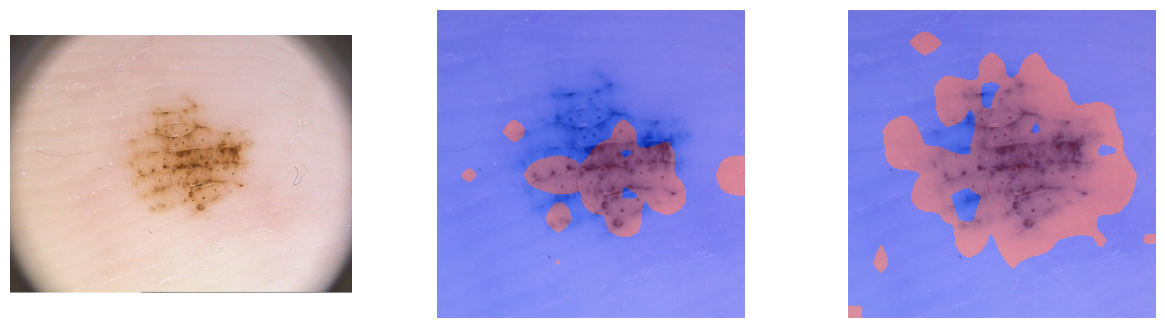

In [14]:
image = Image.open('/content/drive/MyDrive/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp')

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


im = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(im.unsqueeze(0).cuda())

# Get the predicted class index
_, predicted_class_idx = torch.max(output, dim=1)

# Map the predicted class index to its name
predicted_class_name = CLS2IDX[predicted_class_idx.item()]
print("Predicted class:", predicted_class_name)

print_top_classes(output)

# cat - the predicted class
class_0 = generate_visualization(im)


# generate visualization for class 243: 'bull mastiff'
class_1 = generate_visualization(im, class_index=1)


axs[1].imshow(class_0);
axs[1].axis('off');
axs[2].imshow(class_1);
axs[2].axis('off');

## Working above

In [15]:
attribution_generator = LRP(model)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (matmul1): einsum()
        (matmul2): einsum()
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (add1): Add()
      (add2): Add()
      (clone1): Clone()
      (clone2): Cl

Top 3 classes:
	1 : atypical nevus		value = 2.598	 prob = 81.6%
	0 : nevus         		value = 1.106	 prob = 18.3%
	2 : melanoma      		value = -4.355	 prob = 0.1%


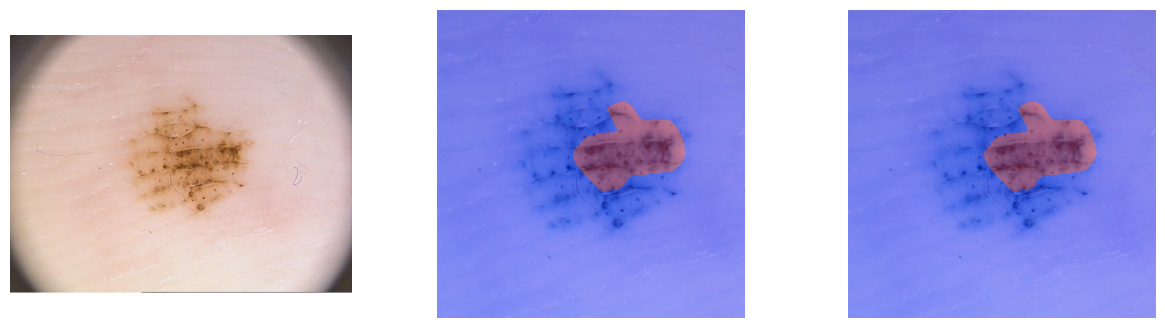

In [16]:
num = str("el2")
folder1 = str("standalone" + num)
folder2 = str("2WAY" + num)
folder3 = str("3WAY" + num)
# /content/drive/MyDrive/PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp
#image = Image.open('samples/' + str(num) + ".png")
image = Image.open('/content/drive/MyDrive/PH2Dataset/PH2 Dataset images/IMD008/IMD008_Dermoscopic_Image/IMD008.bmp')
im = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(im.unsqueeze(0).cuda())
print_top_classes(output)

class_0 = generate_visualization(im)

# generate visualization for class 243: 'bull mastiff'
class_1 = generate_visualization(im, class_index=1)


axs[1].imshow(class_0);
axs[1].axis('off');
axs[2].imshow(class_1);
axs[2].axis('off');

In [20]:

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


"""# LRP"""
def generate_visualization_LRP(original_image, class_index=None, use_thresholding=False):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def generate_saliency_visualization(original_image, class_index=None, use_thresholding=False):
    original_image.requires_grad_()  # Enable gradient tracking for the input image

    # Forward pass through the model
    output = model(original_image.unsqueeze(0).cuda())

    # Select the class for which to compute saliency
    if class_index is not None:
        loss = output[0, class_index]
    else:
        loss = output.max()  # Use the maximum score if no class index is provided

    model.zero_grad()  # Clear previous gradients

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Compute the maximum gradient magnitude across color channels
    saliency = original_image.grad.data.abs().max(dim=0)[0]

    # Move the saliency map to the CPU and convert to a NumPy array
    saliency = saliency.cpu().numpy()

    # Normalize the saliency map to the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Apply thresholding if specified
    if use_thresholding:
        saliency = saliency * 255
        saliency = saliency.astype(np.uint8)
        ret, saliency = cv2.threshold(saliency, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        saliency[saliency == 255] = 1

    # Convert the input image to a NumPy array for visualization
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()

    # Normalize the input image
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    # Overlay the saliency map on the input image
    vis = show_cam_on_image(image_transformer_attribution, saliency)

    # Convert to BGR format for OpenCV
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    return vis

# Attention rollout visualization
def visualize_rollout_heatmap(input_image, start_layer=1, use_thresholding=False):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# CAM visualization
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


In [24]:
import os
import matplotlib.pyplot as plt
from baselines.ViT.ViT_explanation_generator import Baselines
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP

#model = vit_LRP(pretrained=True).cuda()
model.eval()
b = Baselines(model)


# Ensure the folder exists
os.makedirs(folder1, exist_ok=True)


im = transform(image)

# Generating visualizations
lrp_vis = generate_visualization_LRP(im, use_thresholding=True)
saliency_vis = generate_saliency_visualization(im, use_thresholding=True)
rollout_vis = visualize_rollout_heatmap(im, start_layer=2, use_thresholding=True)
cam_vis = visualize_CAM(im, use_thresholding=True)

# Plotting and saving each visualization separately
visualizations = [(lrp_vis, 'LRP'), (saliency_vis, 'Saliency'), (rollout_vis, 'Rollout'), (cam_vis, 'CAM')]

for vis, title in visualizations:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(vis)
    ax.axis('off')
    # ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(folder1, f'{title}.png'))
    plt.close(fig)


AttributeError: 'Attention' object has no attribute 'get_attention_map'

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure the folder exists
os.makedirs(folder2, exist_ok=True)

# Define the attribution functions
def generate_LRP(original_image, class_index):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, lambda img: method1(img, class_index), lambda img: method2(img, class_index), combine_method, use_thresholding)

# Function to visualize all 2-way combinations
def visualize_all_combinations(input_image, combine_method='sqrt', use_thresholding=True):  # Updated to include class index
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))

    # Determine the predicted class index
    output = model(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    print(f"Predicted class index: {class_index}")

    results = []
    for combo in combinations_list:
        print(f"Visualizing {' + '.join(combo)}")
        vis = visualize_combined_methods(input_image, combo[0], combo[1], class_index, combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis))

    return results

# Load image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
im = transform(image).cuda()

# Visualize all combinations
results = visualize_all_combinations(im, combine_method='sqrt', use_thresholding=True)

# Save the results
for name, result in results:
    save_path = os.path.join(folder2, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

# Display the results
fig, axes = plt.subplots(len(results)//2 + len(results) % 2, 2, figsize=(15, len(results)*2))
for ax, (name, result) in zip(axes.flatten(), results):
    ax.imshow(result)
    # ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure the folder exists
os.makedirs(folder3, exist_ok=True)

# Define the attribution functions
def generate_LRP(original_image, class_index):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, methods, class_index, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attributions = []
    for method in methods:
        if method.__name__ in ['generate_LRP', 'generate_saliency', 'generate_CAM']:
            attr = method(input_image, class_index).reshape(1, 1, 14, 14).to(device)
        else:
            attr = method(input_image).reshape(1, 1, 14, 14).to(device)
        attributions.append(attr)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attributions[0] * attributions[1] * attributions[2])
    elif combine_method == 'multiply':
        combined_attr = attributions[0] * attributions[1] * attributions[2]

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# Example usage
def visualize_combined_methods(input_image, method_names, class_index, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    selected_methods = [methods[name] for name in method_names]

    return combine_and_visualize_attributions(input_image, selected_methods, class_index, combine_method, use_thresholding)

# Function to visualize all 3-way combinations
def visualize_all_3way_combinations(input_image, combine_method='sqrt', use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 3))

    # Determine the predicted class index
    output = model(input_image.unsqueeze(0).cuda())
    class_index = output.argmax().item()
    print(f"Predicted class index: {class_index}")

    results = []
    for combo in combinations_list:
        print(f"Visualizing {' + '.join(combo)}")
        vis = visualize_combined_methods(input_image, combo, class_index, combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis))

    return results


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_image = transform(image).cuda()

# Visualize all 3-way combinations
results = visualize_all_3way_combinations(test_image, combine_method='sqrt', use_thresholding=True)

# Save the results
for name, result in results:
    save_path = os.path.join(folder3, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

# Display the results
fig, axes = plt.subplots(len(results)//3 + len(results) % 3, 3, figsize=(15, len(results)*3))
for ax, (name, result) in zip(axes.flatten(), results):
    ax.imshow(result)
    # ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()
